<a href="https://colab.research.google.com/github/giftonovoh-hash/insurance_claim_capstone/blob/main/insurance_claim_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shape: (7160, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB
Claim
0    0.771788
1    0.

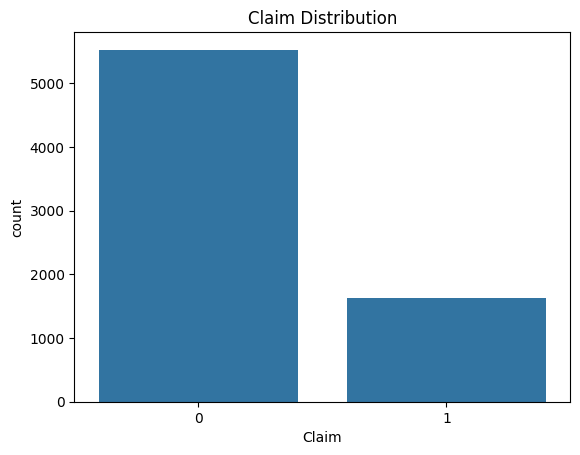

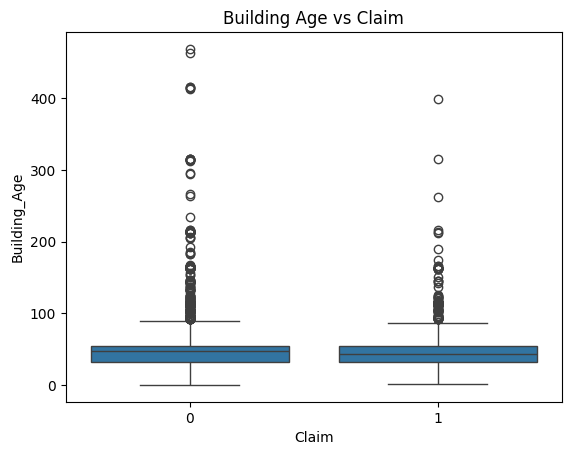

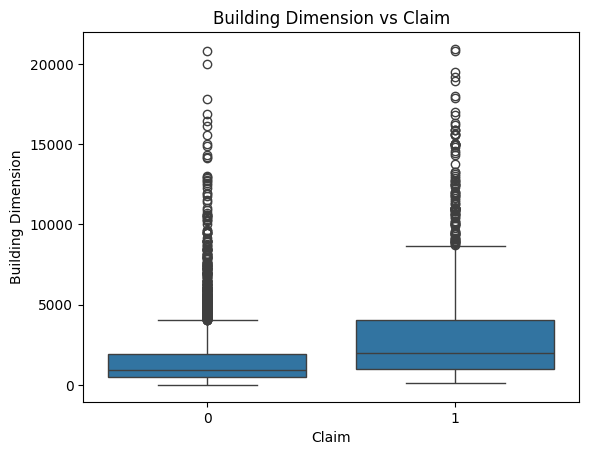

Logistic Regression Results
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1105
           1       0.55      0.18      0.27       327

    accuracy                           0.78      1432
   macro avg       0.67      0.57      0.57      1432
weighted avg       0.74      0.78      0.73      1432

ROC-AUC: 0.6835872528263245
Random Forest Results
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1105
           1       0.46      0.22      0.30       327

    accuracy                           0.76      1432
   macro avg       0.63      0.57      0.58      1432
weighted avg       0.72      0.76      0.73      1432

ROC-AUC: 0.662657921319551


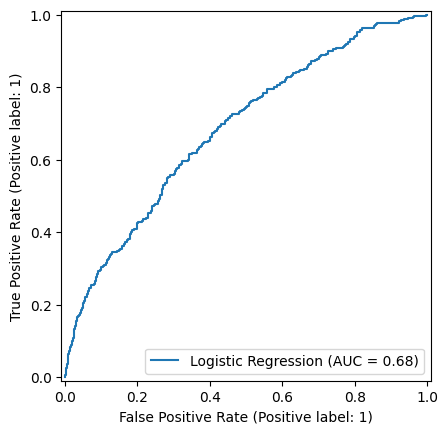

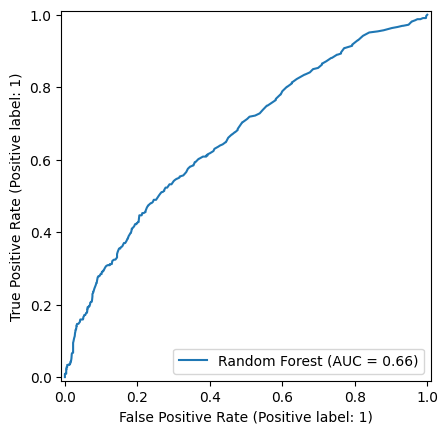

In [14]:
# Insurance Claim Prediction Project

# Author: Gift Onovoh

# Objective: Predict the probability that a building will have at least one insurance claim

# ============================

# 1. Import Libraries

# ============================

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

# ============================

# 2. Load Data

# ============================


df = pd.read_csv("Train_data.csv")

print("Shape:", df.shape)
df.head()

# ============================

# 3. Data Understanding

# ============================

df.info()

# Target distribution

print(df['Claim'].value_counts(normalize=True))

# ============================

# 4. Data Cleaning & Feature Engineering

# ============================

# Drop identifier

df.drop(columns=['Customer Id'], inplace=True)

# Fix NumberOfWindows

df['NumberOfWindows'] = pd.to_numeric(df['NumberOfWindows'], errors='coerce')

# Create Building Age

df['Building_Age'] = df['YearOfObservation'] - df['Date_of_Occupancy']
df.drop(columns=['Date_of_Occupancy'], inplace=True)

# Encode binary categorical variables

binary_maps = {
    'Building_Painted': {'N': 1, 'V': 0},
    'Building_Fenced': {'N': 1, 'V': 0},
    'Garden': {'V': 1, 'O': 0},
    'Settlement': {'U': 1, 'R': 0}
}

for col, mapping in binary_maps.items():
    df[col] = df[col].map(mapping)

# Save cleaned dataset
df.to_csv("cleaned_train_data.csv", index=False)

# ============================

# 5. Exploratory Data Analysis (EDA)

# ============================

# Claim distribution

sns.countplot(x='Claim', data=df)
plt.title('Claim Distribution')
plt.show()

# Building Age vs Claim

sns.boxplot(x='Claim', y='Building_Age', data=df)
plt.title('Building Age vs Claim')
plt.show()

# Building Dimension vs Claim

sns.boxplot(x='Claim', y='Building Dimension', data=df)
plt.title('Building Dimension vs Claim')
plt.show()

# ============================

# 6. Preprocessing for Modeling

# ============================

X = df.drop('Claim', axis=1)
y = df['Claim']

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ============================

# 7. Model 1: Logistic Regression

# ============================

log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)

# Evaluation

y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression Results")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

# ============================

# 8. Model 2: Random Forest

# ============================

rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight='balanced'
    ))
])

rf.fit(X_train, y_train)

# Evaluation

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

# ============================

# 9. ROC Curve Comparison

# ============================

RocCurveDisplay.from_predictions(y_test, y_prob_lr, name='Logistic Regression')
RocCurveDisplay.from_predictions(y_test, y_prob_rf, name='Random Forest')
plt.show()

# ============================

# 10. Conclusion

# ============================

# Random Forest typically outperforms Logistic Regression in ROC-AUC

# Key risk drivers include building age, insured period, and structural features

In [ ]:
!jupyter nbconvert --to html insurance_claim_prediction.ipynb

In [15]:
df.to_csv("cleaned_train_data.csv", index=False)

In [17]:
from google.colab import files
files.download("cleaned_train_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("insurance_claim_Prediction.html")

In [18]:
!ls

 cleaned_train_data.csv  'Train_data (1).csv'   Train_data.csv
 sample_data		 'Train_data (2).csv'


In [16]:
from google.colab import files
uploaded = files.upload()

Saving Train_data.csv to Train_data (2).csv


In [ ]:
import os
os.listdir()

['.config', 'Train_data.csv', 'sample_data']

In [ ]:
from google.colab import files
files.download("cleaned_train_data.csv")